## Постановка задачі

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

Data fields
Each row of the training data contains a click record, with the following features.

ip: ip address of click.
app: app id for marketing.
device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
os: os version id of user mobile phone
channel: channel id of mobile ad publisher
click_time: timestamp of click (UTC)
attributed_time: if user download the app for after clicking an ad, this is the time of the app download
is_attributed: the target that is to be predicted, indicating the app was downloaded
Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

click_id: reference for making predictions
is_attributed: not included

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import ADASYN

In [29]:
#Імпорт данних
train_sample=pd.read_csv('train_sample.csv')
#train=pd.read_csv('train.csv')

In [30]:
#Перевіряємо, що данні імпортувались
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [31]:
#Бачимо, що лише одна колонка має пропущенні данні (пояснюється умовою задачі)
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [32]:
train_sample.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [33]:
#Видаляємо колонку attributed_time, вона вказує на дату встановлення додатку та буде відсутня в тестових данних.
train_sample.drop(['attributed_time'], axis=1, inplace=True)

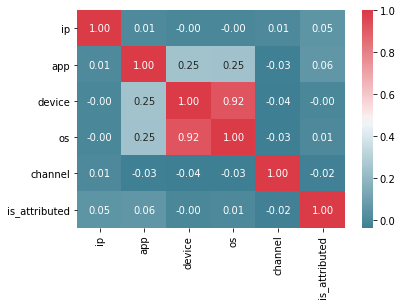

In [34]:
#Перевіряємо на мультиколінерність ознак
train_sample.corr()
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train_sample.corr(), cmap=colormap, annot=True, fmt=".2f")

In [35]:
#Помічаємо високу кореляцію між ознаками ['os'] та ['device']
train_sample.os.describe()

count    100000.000000
mean         22.818280
std          55.943136
min           0.000000
25%          13.000000
50%          18.000000
75%          19.000000
max         866.000000
Name: os, dtype: float64

In [36]:
train_sample.device.describe()

count    100000.000000
mean         21.771250
std         259.667767
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        3867.000000
Name: device, dtype: float64

In [37]:
print(train_sample.os.kurt(), train_sample.os.skew())
print(train_sample.device.kurt(), train_sample.device.skew())

149.12585561063867 11.945416587129792
161.44972810548856 12.70453491871926


In [38]:
#Оскільки ['os'] має більш нормальний розподіл видаляємо ['device']
train_sample.drop(['device'], axis=1, inplace=True)

In [39]:
# Існуючі ознаки мають добру варіативність та є потенційно важливими
train_sample.var()

ip               4.877005e+09
app              2.232484e+02
os               3.129634e+03
channel          1.682838e+04
is_attributed    2.264870e-03
dtype: float64

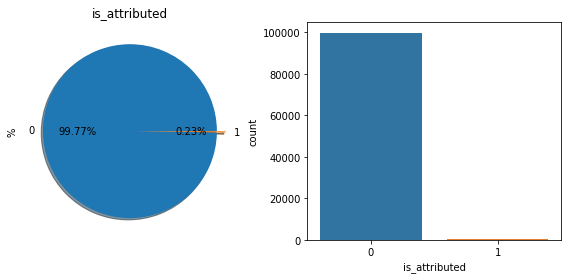

In [40]:
#Легко помітити, маємо незбалансованість класів. Пізніше виконаємо oversampling методом ADASYN
f,ax=plt.subplots(1,2,figsize=(10,4))
train_sample['is_attributed'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%',ax=ax[0],shadow=True)
ax[0].set_title('is_attributed')
ax[0].set_ylabel('%')

sns.countplot('is_attributed',data=train_sample,ax=ax[1])

plt.show()

In [41]:
#Оцінка пропущених данних та унікальних значень змінних
def missingdata(data):
    stats = []
    for col in data.columns:
        stats.append((col, data[col].isnull().sum(), data[col].isnull().sum() * 100 / data.shape[0],data[col].nunique(), data[col].value_counts(normalize=True, dropna=False).values[0] * 100, data[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Feature', 'Total missing', 'Percentage of missing', 'Uniques', '% of values in the biggest cat.', 'DType'])
    #plot barchart:
    stats_df=stats_df.sort_values('Percentage of missing', ascending=False)
    missing_data=stats_df[stats_df['Percentage of missing'] > 0]
    return stats_df.sort_values('Percentage of missing', ascending=False)

missingdata(train_sample)

,Feature,Total missing,Percentage of missing,Uniques,% of values in the biggest cat.,DType
0,ip,0,0.0,34857,0.669,int64
1,app,0,0.0,161,18.279,int64
2,os,0,0.0,130,23.870,int64
3,channel,0,0.0,161,8.114,int64
4,click_time,0,0.0,80350,0.007,object
5,is_attributed,0,0.0,2,99.773,int64


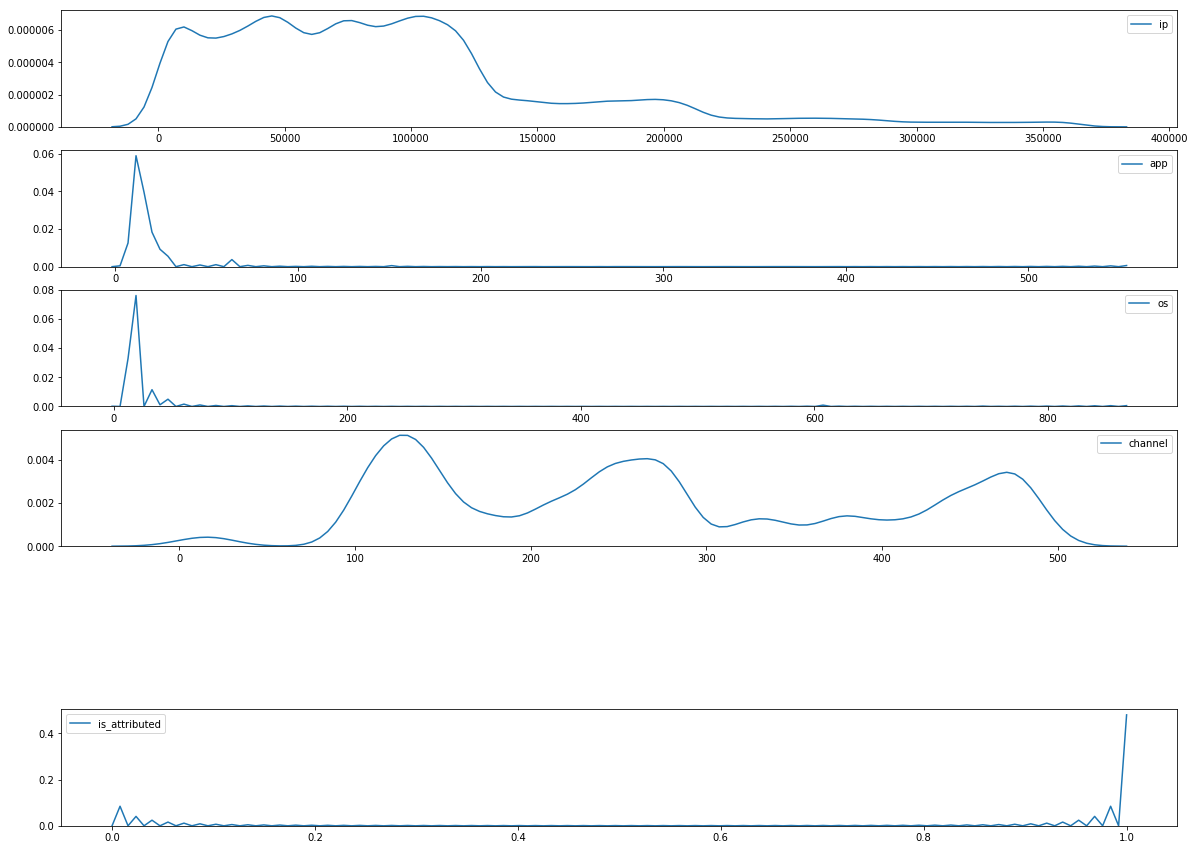

In [42]:
# В нашому випадку більшість ознак - категоріальні. Подивимось на їх розподіл
plt.figure(figsize=(20,15))
for ind, col in enumerate(train_sample.columns):
    if col!='click_time':
        plt.subplot(len(train_sample.columns),1,ind+1)
        sns.kdeplot(train_sample[col])

C:\Anaconda\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


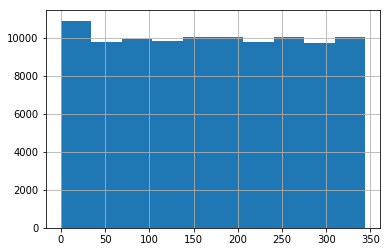

In [43]:
# Ознака ['IP'] має 34857 унікальних значень, виконаємо її кодування з використанням бінів, 
# решту ознак залишимо без змін сподіваючись на потужність LGBM
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=349, encode='ordinal', strategy='quantile')


train_sample['ip']=est.fit_transform(train_sample['ip'].values.reshape(-1, 1))

train_sample['ip'].hist()

# Аналогічне перетворення потрібно буде виконати для тестового датасету est.transform(test['ip']) 

## Feature Engineering

In [44]:
def part_of_day(hour):
    return (
        "morning" if 5 <= hour <= 11
        else
        "afternoon" if 12 <= hour <= 17
        else
        "evening" if 18 <= hour <= 22
        else
        "night"
    )

#convert object to datetime:
train_sample['click_time']=pd.to_datetime(train_sample['click_time'])
#generate 2 columns from datetime - 'Day of week' and 'Part of day':
train_sample['weekday'] = train_sample['click_time'].dt.dayofweek+1
train_sample['day_part'] = train_sample['click_time'].dt.hour
#convert hour to part of day:
train_sample['day_part'] = train_sample['day_part'].apply(lambda x: part_of_day(x))
#one-hot encode 'Part of day', drop 'day_part', 'click_time':
train_sample=pd.concat([train_sample, pd.get_dummies(train_sample['day_part'])], axis=1)

train_sample.drop(['day_part','click_time'],inplace=True,axis=1)

In [45]:
train_sample.columns

Index(['ip', 'app', 'os', 'channel', 'is_attributed', 'weekday', 'afternoon',
       'evening', 'morning', 'night'],
      dtype='object')

In [46]:
#Оскільки датасет містить всього X ознак, додамо "крафтовості"
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
train_X=poly.fit_transform(train_sample[['ip', 'app', 'os', 'channel', 'weekday', 'afternoon',
       'evening', 'morning', 'night']])
feature_names=poly.get_feature_names(['ip', 'app', 'os', 'channel', 'weekday', 'afternoon',
       'evening', 'morning', 'night'])

train_X=pd.DataFrame(train_X, columns=feature_names)

In [47]:
train_X.head()

,ip,app,os,channel,weekday,afternoon,evening,morning,night,ip app,...,weekday afternoon,weekday evening,weekday morning,weekday night,afternoon evening,afternoon morning,afternoon night,evening morning,evening night,morning night
0,187.0,12.0,13.0,497.0,2.0,0.0,0.0,1.0,0.0,2244.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,229.0,25.0,17.0,259.0,2.0,1.0,0.0,0.0,0.0,5725.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,219.0,12.0,19.0,212.0,2.0,0.0,1.0,0.0,0.0,2628.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,203.0,13.0,13.0,477.0,2.0,0.0,0.0,0.0,1.0,2639.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,144.0,12.0,1.0,178.0,4.0,0.0,0.0,1.0,0.0,1728.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 45 columns):
ip                   100000 non-null float64
app                  100000 non-null float64
os                   100000 non-null float64
channel              100000 non-null float64
weekday              100000 non-null float64
afternoon            100000 non-null float64
evening              100000 non-null float64
morning              100000 non-null float64
night                100000 non-null float64
ip app               100000 non-null float64
ip os                100000 non-null float64
ip channel           100000 non-null float64
ip weekday           100000 non-null float64
ip afternoon         100000 non-null float64
ip evening           100000 non-null float64
ip morning           100000 non-null float64
ip night             100000 non-null float64
app os               100000 non-null float64
app channel          100000 non-null float64
app weekday          100000 non-nul

In [49]:
#Виконаємо балансування класів методом ADASYN
def makeOverSamplesADASYN(X,y):
    #X - Independent Variable in DataFrame
    #y - dependent Variable in DataFrame format
    sm = ADASYN(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return (X_res,y_res)

In [50]:
t_x,t_y=makeOverSamplesADASYN(train_X, train_sample['is_attributed'])
df_X=pd.DataFrame(t_x,columns=train_X.columns)
df_Y=pd.DataFrame(t_y, columns=['is_attributed'])

In [51]:
#Видаляємо проміжні датасети

del train_sample, t_x, t_y, train_X

In [52]:
#Перевіряємо результат балансування.
df_Y['is_attributed'].value_counts()

# Ідеально! :)

0    99773
1    99761
Name: is_attributed, dtype: int64

In [53]:
df_X.head(15)

,ip,app,os,channel,weekday,afternoon,evening,morning,night,ip app,...,weekday afternoon,weekday evening,weekday morning,weekday night,afternoon evening,afternoon morning,afternoon night,evening morning,evening night,morning night
0,187.0,12.0,13.0,497.0,2.0,0.0,0.0,1.0,0.0,2244.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,229.0,25.0,17.0,259.0,2.0,1.0,0.0,0.0,0.0,5725.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,219.0,12.0,19.0,212.0,2.0,0.0,1.0,0.0,0.0,2628.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,203.0,13.0,13.0,477.0,2.0,0.0,0.0,0.0,1.0,2639.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,144.0,12.0,1.0,178.0,4.0,0.0,0.0,1.0,0.0,1728.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,201.0,3.0,17.0,115.0,4.0,0.0,0.0,0.0,1.0,603.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
6,36.0,1.0,17.0,135.0,4.0,0.0,0.0,0.0,1.0,36.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
7,266.0,9.0,25.0,442.0,2.0,0.0,0.0,1.0,0.0,2394.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,312.0,2.0,22.0,364.0,3.0,0.0,0.0,1.0,0.0,624.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,285.0,3.0,19.0,135.0,3.0,1.0,0.0,0.0,0.0,855.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
df_X.describe()

,ip,app,os,channel,weekday,afternoon,evening,morning,night,ip app,...,weekday afternoon,weekday evening,weekday morning,weekday night,afternoon evening,afternoon morning,afternoon night,evening morning,evening night,morning night
count,199534.000000,199534.000000,199534.000000,199534.000000,199534.000000,199534.000000,199534.000000,199534.000000,199534.000000,199534.000000,...,199534.000000,199534.000000,199534.000000,199534.000000,199534.0,199534.0,199534.0,199534.0,199534.0,199534.0
mean,203.268457,20.721144,25.400720,240.009481,2.839067,0.245075,0.048995,0.376887,0.329043,4514.312582,...,0.691635,0.102400,1.131398,0.913633,0.0,0.0,0.0,0.0,0.0,0.0
std,111.842585,24.108101,68.817054,125.096598,0.807927,0.399021,0.200099,0.446517,0.433118,6977.702186,...,1.201034,0.448653,1.419214,1.288189,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,102.000000,9.000000,13.000000,134.000000,2.000000,0.000000,0.000000,0.000000,0.000000,774.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,223.000000,15.000000,18.997468,215.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2625.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,310.182110,23.000000,22.437593,325.000000,3.476281,0.470010,0.000000,1.000000,0.898579,5593.040432,...,1.005308,0.000000,2.106836,2.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,344.000000,551.000000,866.000000,498.000000,4.000000,1.000000,1.000000,1.000000,1.000000,169880.000000,...,4.000000,3.000000,4.000000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split

## Побудова та оптимізація моделі класифікації

In [87]:
# Будуємо модель LGBM
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score

lgbm_model=lgbm.LGBMClassifier(objective='binary', verbosity=4, random_state=7,
                              learning_rate=0.1, n_estimators=500, num_leaves= 300,
                              max_depth=8, min_data_in_leaf=10,
                              bagging_fraction=0.9, bagging_freq=1, boosting_type='dart')

#Оптимізацію параметрів виконуємо згідно метирки ROC_AUC

gridParams={#'learning_rate': [0.015, 0.03, 0.1],
#             'num_leaves': [150, 300],
#              'max_depth': [4, 6, 8, 10],
#             'n_estimators': [500, 800, 1000]
#             'boosting_type' : ['gbdt', 'dart'],
#             'max_bin': [510, 750, 1000],
#              'bagging_freq' : [1, 3],
#             'sub_features' : [0.5, 0.8, 1],
#              'bagging_fraction': [0.7, 0.8, 0.9]
#             'lambda_l1': [0, 1, 10],
#             'lambda_l2': [0, 10]
#              'min_data_in_leaf' : [10, 20, 40]
    
}

grid = GridSearchCV(lgbm_model, gridParams, verbose=4, cv=5, n_jobs=-1, scoring='roc_auc')



# Run the grid
grid.fit(df_X, df_Y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 22.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 22.6min finished
C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, boosting_type='dart',
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=8, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
      ...silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbosity=4),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'sub_features': [0.5, 0.8, 1], 'lambda_l1': [0, 1, 10], 'lambda_l2': [0, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=4)

In [88]:
grid.best_params_

{'lambda_l1': 0, 'lambda_l2': 0, 'sub_features': 0.5}

In [82]:
grid.best_score_

0.9999142261808261

In [89]:
params={'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 300}
params.update({'max_depth': 8, 'min_data_in_leaf': 10})
params.update({'objective':'binary', 'random_state':7})
params.update({'bagging_fraction': 0.9, 'bagging_freq': 1, 'boosting_type': 'dart'})
params.update({'lambda_l1': 0, 'lambda_l2': 0, 'sub_features': 0.5})
params

{'learning_rate': 0.1,
 'n_estimators': 500,
 'num_leaves': 300,
 'max_depth': 8,
 'min_data_in_leaf': 10,
 'objective': 'binary',
 'random_state': 7,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'boosting_type': 'dart',
 'lambda_l1': 0,
 'lambda_l2': 0,
 'sub_features': 0.5}

In [61]:
y_pred=lgbm_model.predict(df_X)

print(roc_auc_score(df_Y.values, y_pred))

0.9988022383790626
